In [1]:
# imports
%matplotlib inline
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import glob

In [2]:
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 100  # simulate 100 chromosomes per replicate

In [3]:
# scaled parameters for entire chromosomes
rho = 4*N*r*chromLength
theta = 4*N*mu*chromLength

In [4]:
numReps = 5

In [5]:
# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N)  # rescaled by 2*N

## initial simulation: constant population size history, diploid asexuals

In [6]:
# generate ms commands (but using scrm instead of ms)
# scrm: http://scrm.github.io/ 

msCmds = open('sim_ms_commands.txt', 'w')
for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "sim_data_t{}_rho{}_asex{}_rep{}".format(theta, rho, asexGen, rep)
        msCmd = "scrm 2 {numChroms} -t {theta} -r {rho} {chromLen} | ./add_asex.py - {asexGen} > {filename}".format(numChroms = numChromosomes,
                                                                   theta = theta, rho = rho,
                                                                   chromLen = chromLength, asexGen = asexGen,
                                                                   filename = filename)
        msCmds.write(msCmd+'\n')
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "sim_data_t{}_rho{}_no_asex_rep{}".format(theta, rho, rep)
    msCmd = "scrm 2 {numChroms} -t {theta} -r {rho} {chromLen} > {filename}".format(numChroms = numChromosomes,
                                                               theta = theta, rho = rho,
                                                               chromLen = chromLength,
                                                               filename = filename)
    msCmds.write(msCmd+'\n')
msCmds.close()

Simulate the data.

    cat sim_ms_commands.txt | parallel -j 4
    mkdir -p simdata
    mv sim_data* simdata/

Convert to psmc format.
    
    for file in simdata/sim_data_*
    do
        psmcfilename="$file.psmc"
        ./ms2psmcfa.py $file > $psmcfilename
    done

In [7]:
datadir = "simdata"

In [8]:
# make psmc commands

initialT = "0.5"

psmcCmds = open('sim_psmc_commands.txt', 'w')

for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        datafilename = "{}/sim_data_t{}_rho{}_asex{}_rep{}.psmc".format(datadir, theta, rho, asexGen, rep)
        resultsfilename = "{}/results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsfilenameT = "{}/results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
        psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
        psmcCmds.write(psmcCmd+'\n')
        psmcCmds.write(psmcCmdT+'\n')
# control runs with constant size and no history of asex
psmcCmds = open('sim_psmc_commands_complete.txt', 'w')
for rep in xrange(1,numReps+1):
    datafilename = "{}/sim_data_t{}_rho{}_no_asex_rep{}.psmc".format(datadir, theta, rho, rep)
    resultsfilename = "{}/results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    resultsfilenameT = "{}/results_data_t{}_rho{}_no_asex_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
    psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
    psmcCmds.write(psmcCmd+'\n')
    psmcCmds.write(psmcCmdT+'\n')
psmcCmds.close()

In [9]:
# read and return psmc results as dict

def read_psmc_results(filename):
    results = {}
    results['divtime'] = None  # divtime None by default...
    fin = open(filename,'r')
    for line in fin:
        line = line.strip()
        if line[:2] == 'TR':
            spline = line.split('\t')
            results['theta'] = float(spline[1])
            results['rho'] = float(spline[2])
            continue
        if line[:2] == 'DT':
            results['divtime'] = float(line.split('\t')[1])
            continue
        if line[:2] == 'RS':
            spline = line.split('\t')
            i = int(spline[1])
            ti = float(spline[2])
            lambdai = float(spline[3])
            results['maxi'] = i
            results['t{}'.format(i)] = ti
            results['lambda{}'.format(i)] = lambdai
            continue
    return results

In [10]:
# get psmc data

rows = {}
for asexGen, asexGenUnscaled in zip(asexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        index = 'asex{}_rep{}'.format(asexGen, rep)
        resultsfilename = "{}/results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = asexGenUnscaled
            results['rep'] = rep
            rows[index] = results
        except:
            pass
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        resultsfilename = "{}/results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = asexGenUnscaled
            results['rep'] = rep
            rows[index] = results 
        except:
            pass
        
for rep in xrange(1, numReps+1):
    index = 'noasex_rep{}'.format(rep)
    resultsfilename = "{}/results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    try:
        results = read_psmc_results(resultsfilename)
        results['asex'] = None
        results['rep'] = rep
        rows[index] = results
    except:
        pass

In [11]:
# make a dataframe for psmc data

dat = pd.DataFrame.from_dict(rows, orient = 'index')
maxi = int(dat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
dat = dat[newCols]

In [12]:
# rescaling the population sizes and times

binSize = 100  # we binned the bp's by 100 in the input to PSMC

dat['lambda0'] = dat['theta'] / (4.0*mu) / binSize

dat['divtime'] = 2.0*dat['lambda0'] * dat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    dat[colLam] = dat['lambda0'] * dat[colLam]
    dat[colT] = 2.0*dat['lambda0'] * dat[colT]

In [13]:
# function to plot psmc data

def plot_psmc(axis, ts, lambdas, divtime = None, maxt = None, **plotkwargs):
    newTs = np.repeat(np.array(ts), 2)[1:]
    newLambdas = np.repeat(np.array(lambdas), 2)[:-1]
    if divtime is None:
        axis.plot(newTs, np.log10(newLambdas), '-', **plotkwargs)
    else:
        baseline, = axis.plot(newTs+divtime, np.log10(newLambdas), '-', **plotkwargs)
        if 'color' not in plotkwargs:
            axis.axvline(x = divtime, color = baseline.get_color(), **plotkwargs)
        else:
            axis.axvline(x = divtime, **plotkwargs)
    if maxt is not None:
        axis.set_xlim((0, maxt))
    return

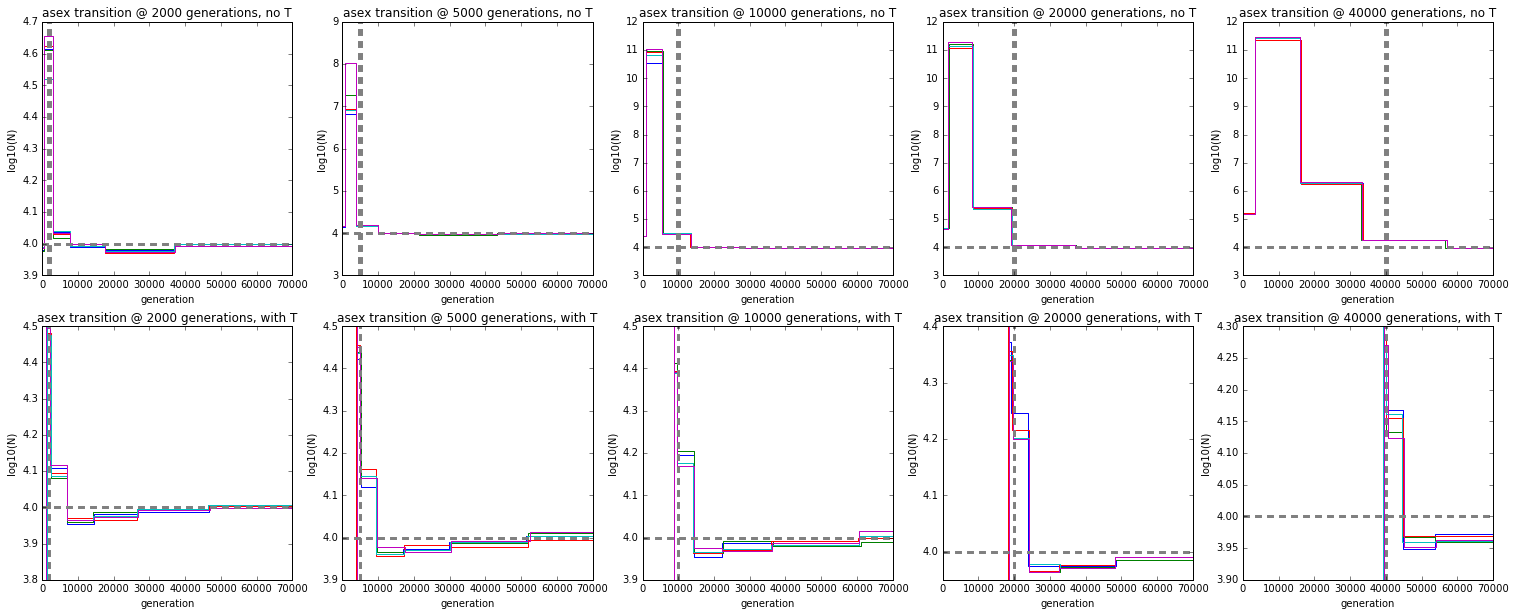

In [14]:
# plot the psmc data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = dat.loc[(dat['asex'] == asexGen) & (np.isnan(dat['divtime'])),:]
    axis = axes[0, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 70000)
        axis.axvline(asexGen, color = 'gray', lw = 5, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = dat.loc[(dat['asex'] == asexGen) & (~np.isnan(dat['divtime'])),:]
    axis = axes[1, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 70000)
        # add true divergence time
        axis.axvline(asexGen, color = 'gray', lw = 3, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')
        

**Figure caption:** Inferred sex-to-asex transition times using the diploid PSMC with simulated diploid asexual genome data. In each panel, there are five lines, one line for each of five replicate datasets. The true population size is shown as a horizontal dashed gray line. The true time of the transition from sexual to asexual reproduction is shown as a vertical dashed gray line. The top row shows the results leaving out the `-T` parameter; the period of asexual reproduction is inferred as a period of increased population size. The lower row shows the effect of enabling the `-T` parameter in PSMC. This parameter is an aborted attempt to model the divergence between two populations; it doesn't work for that scenario, but it is perfect for this particular scenario. In the lower row, the inferred sex-to-asex transition time is shown with the colored solid vertical lines.

It seems like the -T parameter accurately estimates the time since the sex to asex transition time, at least when there is no history of population size changes. The transition is also visible in population size trajectory without the -T option specified (top row), but it is harder to read from the trajectory of N. The estimate of the transition time seems to be somewhat underestimated, with an upwards bias of N directly following the transition. This may be the effect of using SMC math where the SMC' is really needed.

Next: do diploid simulations with recent population growth, see whether PSMC can disentangle these two effects. One reason to be optimistic: In the top row above, the inferred increase in population size in the recent past is several orders of magnitude, which will probably not be the case in nature.

## including historical changes in population size

First going to use "PSMC standard simulation" from their paper, see true population size history in Fig. 2 of Li and Durbin (2011).

The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

Again, we will add $\{2000, 5000, 10000, 20000, 40000\}$ generations of asexual reproduction and see how PSMC determines these transition times from the genome-wide signal of the Meselson effect.

In [15]:
# generate new ms (scrm) commands

stdMsCmd = "scrm 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1"

datadir = "stdsimdata"

stdN0 = 28000

stdAsexGensRescaled = asexGens/(2.0*stdN0)

stdMsCmds = open('sim_ms_commands_standard.txt', 'w')
for asexGen in stdAsexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/standard_sim_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        msCmd = stdMsCmd + ' | ./add_asex.py - {asexGen} > {filename} && ./ms2psmcfa.py {filename} > {filename}.psmc'.format(asexGen=asexGen, filename=filename)
        stdMsCmds.write(msCmd+'\n')

# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/standard_sim_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    msCmd = stdMsCmd + ' > {filename} && ./ms2psmcfa.py {filename} > {filename}.psmc'.format(filename=filename)
    stdMsCmds.write(msCmd+'\n')
stdMsCmds.close()

In [16]:
%%bash

head -n 2 sim_ms_commands_standard.txt

scrm 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 | ./add_asex.py - 0.0357142857143 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1 && ./ms2psmcfa.py stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1.psmc
scrm 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 | ./add_asex.py - 0.0357142857143 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep2 && ./ms2psmcfa.py stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep2 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep2.psmc


In [17]:
%%bash

#ssh peter@ammodramus "mkdir -p /tmp/stdsimdata/"
#scp sim_ms_commands_standard.txt peter@ammodramus:/tmp/

On `ammodramus`:

    cd /tmp/
    cat sim_ms_commands_standard.txt | parallel -j 7

In [18]:
# make the psmc commands too

initialT = "0.5"

psmcCmds = open('sim_psmc_commands_standard.txt', 'w')

datadir = 'stdsimdata'

for asexGen in stdAsexGensRescaled:
    for rep in xrange(1, numReps+1):
        datafilename = "{}/standard_sim_data_t{}_rho{}_asex{}_rep{}.psmc".format(datadir, theta, rho, asexGen, rep)
        resultsfilename = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsfilenameT = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
        psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
        psmcCmds.write(psmcCmd+'\n')
        psmcCmds.write(psmcCmdT+'\n')
# control runs with constant size and no history of asex
psmcCmds = open('sim_psmc_commands_complete.txt', 'w')
for rep in xrange(1,numReps+1):
    datafilename = "{}/standard_sim_data_t{}_rho{}_no_asex_rep{}.psmc".format(datadir, theta, rho, rep)
    resultsfilename = "{}/standard_results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    resultsfilenameT = "{}/standard_results_data_t{}_rho{}_no_asex_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
    psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
    psmcCmds.write(psmcCmd+'\n')
    psmcCmds.write(psmcCmdT+'\n')
psmcCmds.close()

In [19]:
%%bash

head -n 2 sim_psmc_commands_standard.txt

psmc stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1.psmc > stdsimdata/standard_results_data_t6000.0_rho4000.0_asex0.0357142857143_rep1
psmc stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1.psmc -T 0.5 > stdsimdata/standard_results_data_t6000.0_rho4000.0_asex0.0357142857143_rep1_T


In [20]:
%%bash

#scp sim_psmc_commands_standard.txt peter@ammodramus:/tmp/

Combined ms and psmc commands into one big file, sent off with `cat | parallel`

In [21]:
# get psmc data for standard simulations

datadir = 'stdsimdata'

stdrows = {}
for asexGen, stdAsexGenUnscaled in zip(stdAsexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        index = 'std_asex{}_rep{}'.format(asexGen, rep)
        resultsfilename = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = stdAsexGenUnscaled
            results['rep'] = rep
            stdrows[index] = results
        except:
            pass
        index = 'std_asex{}_rep{}_T'.format(asexGen, rep)
        resultsfilename = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = stdAsexGenUnscaled
            results['rep'] = rep
            stdrows[index] = results 
        except:
            pass
        
_ = '''
for rep in xrange(1, numReps+1):
    index = 'noasex_rep{}'.format(rep)
    resultsfilename = "{}/results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    try:
        results = read_psmc_results(resultsfilename)
        results['asex'] = None
        results['rep'] = rep
        rows[index] = results
    except:
        pass
'''

In [22]:
# make a dataframe for standard (var-N) psmc data

stddat = pd.DataFrame.from_dict(stdrows, orient = 'index')
maxi = int(dat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
stddat = stddat[newCols]

The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

Again, we will add $\{2000, 5000, 10000, 20000, 40000\}$ generations of asexual reproduction and see how PSMC determines these transition times from the genome-wide signal of the Meselson effect.

In [23]:
trueTs = np.array([0,1120,4200,140000])
trueNs = np.array([28000,1400,14000,28000])

In [24]:
# rescaling the population sizes and times in the standard (var-N) simulations

binSize = 100  # we binned the bp's by 100 in the input to PSMC

mustd = 2.44e-8

stddat['lambda0'] = stddat['theta'] / (4.0*mustd) / binSize

stddat['divtime'] = 2.0*stddat['lambda0'] * stddat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    stddat[colLam] = stddat['lambda0'] * stddat[colLam]
    stddat[colT] = 2.0*stddat['lambda0'] * stddat[colT]

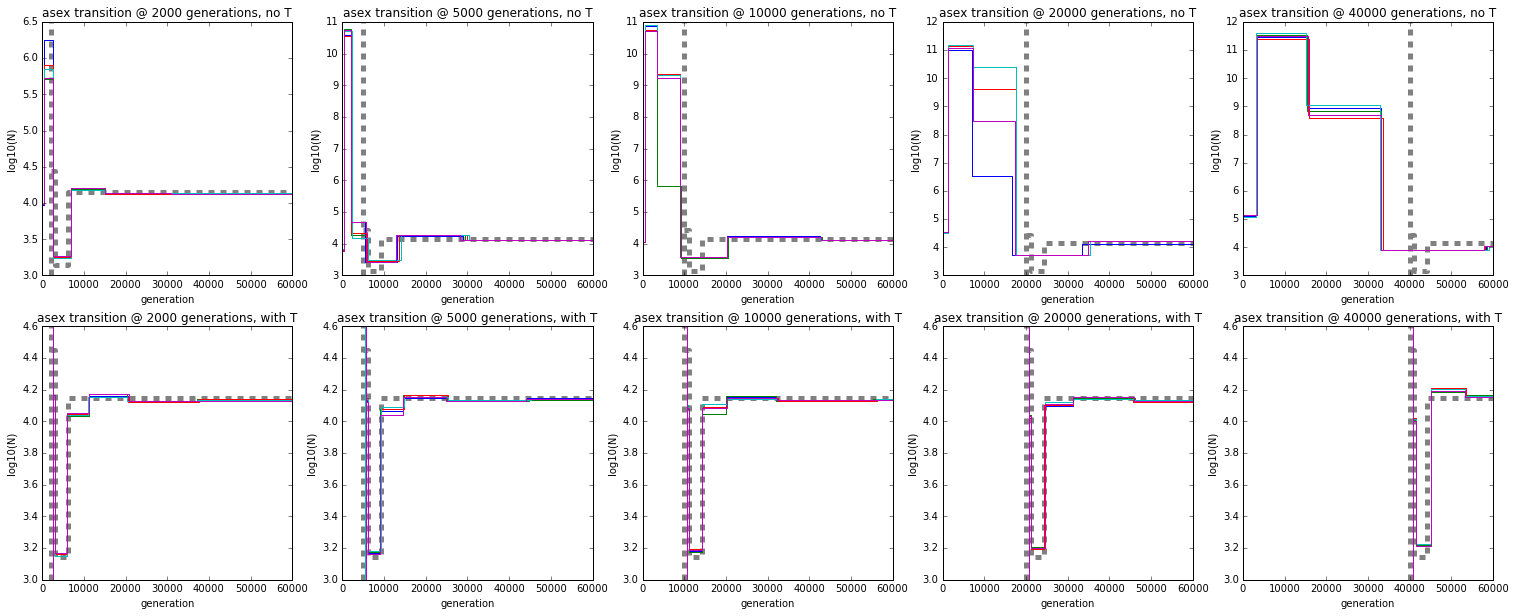

In [25]:
###### plot the std psmc data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = stddat.loc[(stddat['asex'] == asexGen) & (np.isnan(stddat['divtime'])),:]
    axis = axes[0, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = stddat.loc[(stddat['asex'] == asexGen) & (~np.isnan(stddat['divtime'])),:]
    axis = axes[1, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        # add true divergence time
        #axis.axvline(asexGen, color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')

**Figure description:** Divergence time and demographic inference from simulated diploid asexual genome data. The demographic history (i.e., historical population size trajectory) of the sexual ancestor is the "standard" PSMC simulation described above, shown with the dashed gray line. Each column shows results of a diploid asexual lineage that transitioned from a diploid sexual ancestor at some point in the past, which increases moving from the first to last column. This transition time is marked with a vertical dashed gray line.

In each panel, the replicate simulations are different colored lines. The top row shows the past that is inferred when the `-T` parameter is disabled, the default behavior. In this case PSMC infers an astronomically large population size during the period of asexual reproduction. The bottom row shows the same simulations analyzed with the asexual divergence `-T` parameter enabled. In these figures, the inferred divergence times are the colored vertical lines.

It is very encouraging to see that (this particular) variable-population-size history does not affect the inference of the sex-to-asex transition time and that the population size history is still recoverable.


Next: simulate triploid data, with and without variable population size history, "diploidize" the genotypes, and run PSMC.

### A note: information in polymorphism density vs genotype / SFS

The diploid PSMC takes into account only the positions of the polymorphic positions; it ignores the particular genotypes. It is encouraging that the diploid PSMC model seems to accurately infer the sex-to-asex transition time. For a hypothetical *diploid* asexual species, the only information about the Meselson effect contained in a single genome is in the spacing of polymorphisms.

For a triploid asexual species, there is also a huge amount of information in genotypes, which is the (unfolded) site-frequency spectrum of the polymorphisms. (By genotype, I mean the count of 0,1,2, or 3 derived allele copies at a site. They would be established by polarizing against the *P. estuarinas* outgroup.) Consider the following: in a sexual panmictic population with constant population size, the expected number of singletons in a sample of size $n=3$ is $\theta$, and the expected number of doubletons is $\theta/2$, where $\theta = 4N\mu$.

If a triploid asexual lineage was derived from three sexual haplotypes at time $T$ in the past (measured in units of $2N$ generations), then (due to the Meselson effect), any mutations that occurred during that interval $[0,T)$ of asexual reproduction will be present in only one copy in the lineage's genome. Thus apomictic asexual reproduction increases the expected number of singletons but not the number of doubletons.

It's straightforward to work out an estimator for this time $T$ based on the ratio of singleton vs. doubleton genotypes in the genome. The additional number of singletons expected due to the Meselson effect is $3\theta T/2$, so the total number of singletons expected is $\theta + 3\theta T/2 = \frac{2\theta + 3\theta T}{2}.$ The expected number of doubletons is still $\theta/2$, so the expected total number polymorphisms is
$\frac{3\theta+3\theta T}{2}$. The expected fraction of singleton genotypes is thus

$$
R = \frac{2+3T}{3+3T},
$$
which gives the estimator

$$
\hat{T} = \frac{3\hat{R}-2}{3(1-\hat{R})},
$$
where $\hat{R}$ is the observed fraction of polymorphic sites that are singleton genotypes. This estimator works well for simulated data but relies heavily on the assumption that the sexual ancestral population had a constant size. This estimator could be extended to any demographic history of the sexual ancestor, so long as it is possible to calculate the site-frequency spectrum for that demographic history. (There are methods of doing this.)

But generally speaking, it will be impossible to disentangle changes in the sexual ancestor's population size from the timing of the sex-to-asex transition time using only the genome-wide SFS (i.e., using this estimator). However, it may be possible to rule out demographic history as a plausible explanation if the observed value of $\hat{R}$ is extreme enough.

A fully-specified triploid PSMC-style model with a $T$ parameter built into the model would take full advantage of the information contained in both the spacing of polymorphic sites and the genotype frequency spectrum. I am confident that this model would have excellent power to determine the sex-to-asex transition time.

# triploid data with constant N

In [27]:
# simulate triploid data

# these are the same parameters as the constant-N simulations before,
# but now simulating triploid data with ms

mu = 1.5e-8  # mutation rate
# simulate triploid data
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 100  # simulate 100 chromosomes per replicate

In [28]:
# scaled parameters for entire chromosomes
rho = 4*N*r*chromLength
theta = 4*N*mu*chromLength

In [29]:
# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N)  # rescaled by 2*N

In [32]:
# generate ms commands (but using scrm instead of ms)
# scrm: http://scrm.github.io/ 

datadir = "triploidconstant"

initialT = 0.5

trcNresultsFilenames = []

msCmds = open('sim_ms_commands_constant_triploid.txt', 'w')
for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/sim_data_t{}_rho{}_asex{}_triploid_rep{}".format(datadir, theta, rho, asexGen, rep)
        msCmd = "scrm 3 {numChroms} -t {theta} -r {rho} {chromLen} | ./add_asex.py - {asexGen} --triploid > {filename}".format(numChroms = numChromosomes,
                                                                   theta = theta, rho = rho,
                                                                   chromLen = chromLength, asexGen = asexGen,
                                                                   filename = filename)
        psmcfaFilename = filename + '.psmc'
        ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
        resultsFilename = "{}/results_t{}_rho{}_asex{}_triploid_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_triploid_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
        psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
        wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
        msCmds.write(wholeCmd+'\n')
        trcNresultsfilenames.extend([resultsFilename, resultsFilenameT])
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/sim_data_t{}_rho{}_no_asex_triploid_rep{}".format(datadir, theta, rho, rep)
    msCmd = "scrm 3 {numChroms} -t {theta} -r {rho} {chromLen} > {filename}".format(numChroms = numChromosomes,
                                                               theta = theta, rho = rho,
                                                               chromLen = chromLength,
                                                               filename = filename)
    psmcfaFilename = filename + '.psmc'
    ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
    resultsFilename = "{}/results_t{}_rho{}_no_asex_triploid_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_triploid_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
    psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
    wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
    msCmds.write(wholeCmd+'\n')
    trcNresultsfilenames.extend([resultsFilename, resultsFilenameT])
msCmds.close()

In [33]:
%%bash

head -n 1 'sim_ms_commands_constant_triploid.txt'
tail -n 1 'sim_ms_commands_constant_triploid.txt'

scrm 3 100 -t 6000.0 -r 4000.0 10000000 | ./add_asex.py - 0.1 --triploid > triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1 && ./ms2psmcfa.py triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1 > triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1.psmc && psmc triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1.psmc > triploidconstant/results_t6000.0_rho4000.0_asex0.1_triploid_rep1 && psmc triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1.psmc -T 0.5 > triploidconstant/results_t6000.0_rho4000.0_asex0.1_triploid_rep1_T
scrm 3 100 -t 6000.0 -r 4000.0 10000000 > triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5 && ./ms2psmcfa.py triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5 > triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5.psmc && psmc triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5.psmc > triploidconstant/results_t6000.0_rho4000.0_no_asex_trip

In [111]:
%%bash

#scp sim_ms_commands_constant_triploid.txt peter@ammodramus:/tmp/

In [70]:
trcNrows = {}
for asexGenRescaled, asexGen in zip(asexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        resultsFilename = "{}/results_t{}_rho{}_asex{}_triploid_rep{}".format(datadir, theta, rho, asexGenRescaled, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_triploid_rep{}_T".format(datadir, theta, rho, asexGenRescaled, rep)
        
        index = 'asex{}_rep{}'.format(asexGen, rep)
        results = read_psmc_results(resultsFilename)
        results['asex'] = asexGen
        results['rep'] = rep
        trcNrows[index] = results
        
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        results = read_psmc_results(resultsFilenameT)
        results['asex'] = asexGen
        results['rep'] = rep
        trcNrows[index] = results
        
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    resultsFilename = "{}/results_t{}_rho{}_no_asex_triploid_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_triploid_rep{}_T".format(datadir, theta, rho, rep)
    
    index = 'no_asex_rep{}'.format(rep)
    results = read_psmc_results(resultsFilename)
    results['asex'] = None
    results['rep'] = rep
    trcNrows[index] = results
    
    index = 'no_asex_rep{}_T'.format(rep)
    results = read_psmc_results(resultsFilenameT)
    results['asex'] = None
    results['rep'] = rep
    trcNrows[index] = results


In [71]:
trcNrows

{'asex10000_rep1': {'asex': 10000,
  'divtime': None,
  'lambda0': 2704819.205631,
  'lambda1': 2704819.205631,
  'lambda10': 0.190295,
  'lambda11': 0.190295,
  'lambda12': 0.190295,
  'lambda13': 0.168081,
  'lambda14': 0.168081,
  'lambda15': 0.168081,
  'lambda16': 0.163905,
  'lambda17': 0.163905,
  'lambda18': 0.163905,
  'lambda19': 0.155577,
  'lambda2': 2704819.205631,
  'lambda20': 0.155577,
  'lambda21': 0.155577,
  'lambda22': 0.155577,
  'lambda3': 2704819.205631,
  'lambda4': 1.738567,
  'lambda5': 1.738567,
  'lambda6': 1.738567,
  'lambda7': 0.266468,
  'lambda8': 0.266468,
  'lambda9': 0.266468,
  'maxi': 22,
  'rep': 1,
  'rho': 0.058265,
  't0': 0.0,
  't1': 0.016885,
  't10': 0.375969,
  't11': 0.456335,
  't12': 0.55027,
  't13': 0.660067,
  't14': 0.788402,
  't15': 0.938407,
  't16': 1.113739,
  't17': 1.318676,
  't18': 1.558216,
  't19': 1.838201,
  't2': 0.03662,
  't20': 2.165461,
  't21': 2.547979,
  't22': 2.995083,
  't3': 0.059688,
  't4': 0.086651,
  't5

In [72]:
# make a dataframe for standard (var-N) psmc data

trcNdat = pd.DataFrame.from_dict(trcNrows, orient = 'index')
maxi = int(trcNdat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
trcNdat = trcNdat[newCols]

In [73]:
# rescaling the population sizes and times in the standard (var-N) simulations

binSize = 100  # we binned the bp's by 100 in the input to PSMC

trcNdat['lambda0'] = trcNdat['theta'] / (4.0*mu) / binSize

trcNdat['divtime'] = 2.0*trcNdat['lambda0'] * trcNdat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    trcNdat[colLam] = trcNdat['lambda0'] * trcNdat[colLam]
    trcNdat[colT] = 2.0*trcNdat['lambda0'] * trcNdat[colT]

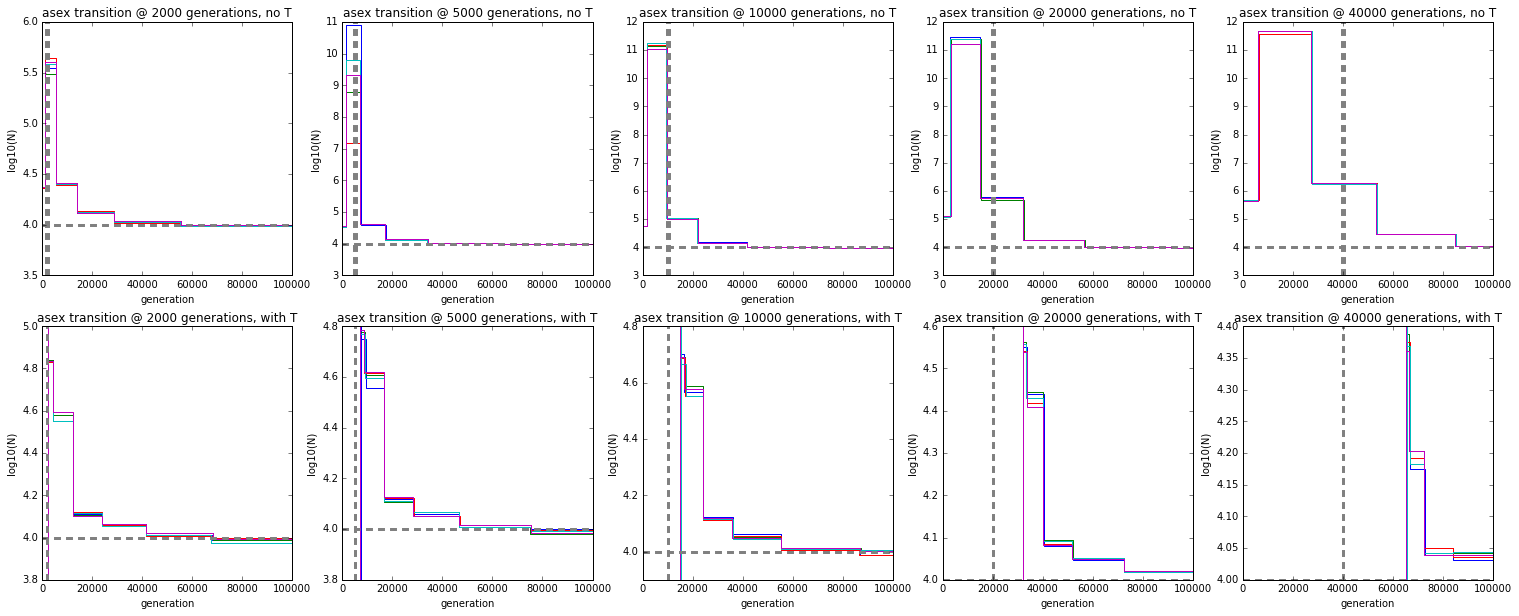

In [76]:
# plot the triploid constant-N data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = trcNdat.loc[(trcNdat['asex'] == asexGen) & (np.isnan(trcNdat['divtime'])),:]
    axis = axes[0, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 100000)
        axis.axvline(asexGen, color = 'gray', lw = 5, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')
    # second row: with T
    datp = trcNdat.loc[(trcNdat['asex'] == asexGen) & (~np.isnan(trcNdat['divtime'])),:]
    axis = axes[1, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 100000)
        # add true divergence time
        axis.axvline(asexGen, color = 'gray', lw = 3, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')
        

Also need to plot control graphs here, make sure inferred T is zero.

Summarize these.

Next, simulations of diploid and triploid data with recent exponential growth.